In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [25]:
# rpy2 (for AdhereR)
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

In [26]:
# Function to compute Shannon entropy of clustering (ignoring noise, i.e. label -1)
def clustering_entropy(labels):
    # Filter out noise points
    valid = labels[labels != -1]
    if len(valid) == 0:
        return None
    unique, counts = np.unique(valid, return_counts=True)
    p = counts / counts.sum()
    # Compute entropy: higher means a more balanced cluster distribution.
    entropy = -np.sum(p * np.log(p))
    return entropy

In [27]:
# -------------------------
# Load dataset – uses AdhereR's med.events
# -------------------------
pandas2ri.activate()
robjects.r('library(AdhereR)')
med_events_r = robjects.r('med.events')
med_events = pandas2ri.rpy2py(med_events_r)

In [28]:
ExamplePats = med_events.copy()
tidy = ExamplePats.copy()
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

In [29]:
# -------------------------
# SEE using KMeans with Silhouette Analysis
# -------------------------
def See_kmeans(arg1):
    """
    Existing clustering procedure with K-means:
    - Filters the data for the given ATC,
    - Samples random consecutive prescription pairs,
    - Computes event intervals and its ECDF,
    - Uses gaussian_kde over the log-transformed intervals,
    - Clusters the ECDF x-values using K-means (with silhouette-based optimal k),
    - Computes cluster statistics and assigns a cluster-based median for each patient,
    - Returns the final merged dataframe and clustering details.
    """
    # Filter rows where ATC equals arg1
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()

    # Take a copy (for later merging)
    drug_see_p0 = C09CA01.copy()

    # Sort by pnr and eksd; compute previous prescription date per patient
    drug_see_p1 = C09CA01.sort_values(['pnr', 'eksd']).copy()
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd']).copy()

    # For each patient, randomly sample one row (with a fixed seed)
    drug_see_p1 = (drug_see_p1
                   .groupby('pnr', group_keys=False)
                   .apply(lambda x: x.sample(1, random_state=1234))
                   .reset_index(drop=True))
    # Retain key columns
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]

    # Compute event interval (in days)
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    # Compute the ECDF function using statsmodels
    ecdf_func = ECDF(drug_see_p1['event.interval'].values)

    # Use sorted event intervals as x-values
    x_vals = np.sort(drug_see_p1['event.interval'].values)
    y_vals = ecdf_func(x_vals)

    df_ecdf = pd.DataFrame({'x': x_vals, 'y': y_vals})
    
    # Retain the lower 80% of the ECDF (i.e. where cumulative probability <= 0.8)
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()
    
    # Subset data for event intervals up to the 80th percentile
    drug_see_p2 = drug_see_p1[drug_see_p1['event.interval'] <= ni].copy()
    
    # --- Density estimation on log(event.interval) ---
    log_intervals = np.log(drug_see_p2['event.interval'])
    kde = gaussian_kde(log_intervals)
    x_grid = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_kde = kde(x_grid)
    
    # Prepare KDE points for clustering.
    kde_df = pd.DataFrame({'x': x_grid, 'y': y_kde})
    scaler = StandardScaler()
    kde_scaled = scaler.fit_transform(kde_df)

    # --- Determine optimal number of clusters via silhouette analysis for KMeans ---
    silhouette_scores = {}
    for k in range(2, min(11, len(kde_scaled))):
        km = KMeans(n_clusters=k, random_state=1234)
        labels = km.fit_predict(kde_scaled)
        score = silhouette_score(kde_scaled, labels)
        silhouette_scores[k] = score
    if silhouette_scores:
        optimal_k = max(silhouette_scores, key=silhouette_scores.get)
    else:
        optimal_k = 1

    # Plot silhouette scores
    plt.figure(figsize=(8, 5))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
    plt.title("KMeans Silhouette Analysis")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    # --- K-means clustering on the ECDF x values (event intervals) ---
    km_ecdf = KMeans(n_clusters=optimal_k, random_state=1234)
    df_ecdf['cluster'] = km_ecdf.fit_predict(df_ecdf[['x']])
    
    # For each cluster, compute the min, max, and median on the log scale then exponentiate
    cluster_stats = (df_ecdf.groupby('cluster')['x']
                     .agg(min_log=lambda x: np.log(x).min(),
                          max_log=lambda x: np.log(x).max(),
                          median_log=lambda x: np.log(x).median())
                     .reset_index())
    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    # --- Cross join drug_see_p1 with cluster_stats ---
    drug_see_p1['_key'] = 1
    cluster_stats['_key'] = 1
    cross_df = pd.merge(drug_see_p1, cluster_stats, on='_key').drop('_key', axis=1)
    
    # For each row, assign Final_cluster if the event interval falls within the cluster’s [Minimum, Maximum]
    cross_df['Final_cluster'] = cross_df.apply(
        lambda row: row['cluster'] if (row['event.interval'] >= row['Minimum'] and row['event.interval'] <= row['Maximum'])
        else np.nan, axis=1)
    results = cross_df.dropna(subset=['Final_cluster']).copy()
    results = results[['pnr', 'Median', 'Final_cluster']]

    # Determine the most common cluster and set a default median
    most_common_cluster = results['Final_cluster'].value_counts().idxmax()
    default_median = cluster_stats.loc[cluster_stats['cluster'] == most_common_cluster, 'Median'].values[0]

    # Merge cluster assignments back into drug_see_p1 and compute the difference to the median
    drug_see_p1 = pd.merge(drug_see_p1, results, on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(default_median)
    drug_see_p1['Cluster'] = drug_see_p1['Final_cluster'].fillna(0)
    drug_see_p1['test'] = (drug_see_p1['event.interval'] - drug_see_p1['Median']).round(1)
    
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster', 'test']]
    
    # Finally, merge these assignments back into the original filtered data (drug_see_p0)
    final_df = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    final_df['Median'] = final_df['Median'].fillna(default_median)
    final_df['Cluster'] = final_df['Cluster'].fillna(0)

    # Return both the final merged dataframe and the clustering details (with the 'test' differences)
    return final_df, drug_see_p1

In [30]:
# -------------------------
# SEE using DBSCAN with Shannon
# -------------------------
def See_dbscan(arg1, eps_range=(0.05, 1.0), num_eps=100, min_samples=3):
    """
    Clustering using DBSCAN with entropy-based optimal eps.
    The function follows steps very similar to See_kmeans up until the clustering stage.
    Instead of using KMeans on the ECDF x values, it scales the x data and searches over a
    range of eps values to select the eps that yields the highest entropy score (computed on non-noise points).
    The chosen DBSCAN clustering is then used to compute cluster summary statistics and to assign each patient a median.
    """
    # Filter rows where ATC equals arg1
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    drug_see_p0 = C09CA01.copy()

    # Compute previous prescription date per patient and select one random pair per patient
    drug_see_p1 = C09CA01.sort_values(['pnr', 'eksd']).copy()
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd']).copy()
    drug_see_p1 = (drug_see_p1
                   .groupby('pnr', group_keys=False)
                   .apply(lambda x: x.sample(1, random_state=1234))
                   .reset_index(drop=True))
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(float)

    # Compute the ECDF on event intervals
    ecdf_func = ECDF(drug_see_p1['event.interval'].values)
    x_vals = np.sort(drug_see_p1['event.interval'].values)
    y_vals = ecdf_func(x_vals)
    df_ecdf = pd.DataFrame({'x': x_vals, 'y': y_vals})
    
    # Limit analysis to the lower 80% of the ECDF
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()
    drug_see_p2 = drug_see_p1[drug_see_p1['event.interval'] <= ni].copy()

    # --- Density estimation on log(event.interval) ---
    log_intervals = np.log(drug_see_p2['event.interval'])
    kde = gaussian_kde(log_intervals)
    x_grid = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_kde = kde(x_grid)
    
    # (Optional: you could use the KDE output for additional insights)
    kde_df = pd.DataFrame({'x': x_grid, 'y': y_kde})
    
    # --- DBSCAN clustering on ECDF x values ---
    # We cluster using df_ecdf[['x']]. First, scale the x values.
    scaler = StandardScaler()
    df_ecdf_scaled = scaler.fit_transform(df_ecdf[['x']])
    
    # Search for an optimal eps by iterating over a range of eps values and computing entropy scores
    eps_values = np.linspace(eps_range[0], eps_range[1], num_eps)
    entropy_scores = {}
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="braycurtis", n_jobs=-1)
        labels = dbscan.fit_predict(df_ecdf_scaled)
        # Exclude noise label (-1) for entropy computation
        labels_valid = labels[labels != -1]
        if len(np.unique(labels_valid)) < 2:
            continue  # need at least 2 clusters for entropy score
        mask = labels != -1
        score = clustering_entropy(labels[mask])
        entropy_scores[eps] = score
    if entropy_scores:
        best_eps = min(entropy_scores, key=entropy_scores.get)
    else:
        best_eps = eps_range[0]  # default eps if no suitable eps found

    # Plot entropy scores for DBSCAN eps values
    plt.figure(figsize=(8, 5))
    plt.plot(list(entropy_scores.keys()), list(entropy_scores.values()), marker='o')
    plt.title("DBSCAN Entropy Analysis (eps search)")
    plt.xlabel("eps value")
    plt.ylabel("Entropy Score")
    plt.show()

    # Run DBSCAN with the best eps value
    dbscan_final = DBSCAN(eps=best_eps, min_samples=min_samples, metric="braycurtis", n_jobs=-1)
    df_ecdf['cluster'] = dbscan_final.fit_predict(df_ecdf_scaled)
    
    # Compute cluster summary statistics on the raw x scale for non-noise clusters
    cluster_stats = (df_ecdf[df_ecdf['cluster'] != -1].groupby('cluster')['x']
                     .agg(min_log=lambda x: np.log(x).min(),
                          max_log=lambda x: np.log(x).max(),
                          median_log=lambda x: np.log(x).median())
                     .reset_index())
    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])
    
    # If no clusters were identified (i.e. all noise), assign default values
    if cluster_stats.empty:
        default_median = np.median(drug_see_p1['event.interval'])
        # Assign cluster 0 to all patients
        drug_see_p1['Cluster'] = 0
        drug_see_p1['Median'] = default_median
    else:
        # --- Cross join drug_see_p1 with cluster_stats ---
        drug_see_p1['_key'] = 1
        cluster_stats['_key'] = 1
        cross_df = pd.merge(drug_see_p1, cluster_stats, on='_key').drop('_key', axis=1)

        # For each row, assign Final_cluster if the event interval falls within the cluster’s [Minimum, Maximum]
        cross_df['Final_cluster'] = cross_df.apply(
            lambda row: row['cluster'] if (row['event.interval'] >= row['Minimum'] and row['event.interval'] <= row['Maximum'])
            else np.nan, axis=1)
        results = cross_df.dropna(subset=['Final_cluster']).copy()
        results = results[['pnr', 'Median', 'Final_cluster']]
        
        # Determine the most common cluster and set a default median
        most_common_cluster = results['Final_cluster'].value_counts().idxmax()
        default_median = cluster_stats.loc[cluster_stats['cluster'] == most_common_cluster, 'Median'].values[0]

        # Merge cluster assignments back into drug_see_p1
        drug_see_p1 = pd.merge(drug_see_p1, results, on='pnr', how='left')
        drug_see_p1['Median'] = drug_see_p1['Median'].fillna(default_median)
        drug_see_p1['Cluster'] = drug_see_p1['Final_cluster'].fillna(0)
    
    # Compute the difference between the event interval and the assigned median
    drug_see_p1['test'] = (drug_see_p1['event.interval'] - drug_see_p1['Median']).round(1)
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster', 'test']]
    
    # Merge these assignments back into the original filtered data
    final_df = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    final_df['Median'] = final_df['Median'].fillna(default_median)
    final_df['Cluster'] = final_df['Cluster'].fillna(0)

    return final_df, drug_see_p1

In [31]:
def plot_cluster_comparison(cluster_details_km, cluster_details_dbscan, med_name="Medication"):
    """
    Compare KMeans raw durations (between eksd dates) with DBSCAN test values (distance from cluster median).
    
    KMeans: Shows how consistent the time between prescriptions is (Duration).
    DBSCAN: Shows how tight the clustering is (test value = deviation from cluster median).
    
    Parameters:
        cluster_details_km (DataFrame): Must contain 'pnr' and 'eksd' (datetime).
        cluster_details_dbscan (DataFrame): Must contain 'pnr' and 'test' (numeric).
        med_name (str): Name of the medication (used in plot title).
    """
    # --- KMEANS: compute raw durations ---
    df_km = cluster_details_km.sort_values(['pnr', 'eksd']).copy()
    df_km['prev_eksd'] = df_km.groupby('pnr')['eksd'].shift(1)
    df_km['Duration'] = (df_km['eksd'] - df_km['prev_eksd']).dt.days
    df_km = df_km.dropna(subset=['Duration'])
    df_km['value'] = df_km['Duration']
    df_km['method'] = 'KMeans'

    # --- DBSCAN: use test values (deviation from cluster median) ---
    df_db = cluster_details_dbscan[['pnr', 'test']].copy()
    df_db = df_db.dropna(subset=['test'])
    df_db['value'] = df_db['test']
    df_db['method'] = 'DBSCAN'

    # Combine for comparison
    combined_df = pd.concat([df_km, df_db], ignore_index=True)

    # Mann–Whitney U test between KMeans durations and DBSCAN test values
    km_values = combined_df[combined_df['method'] == 'KMeans']['value']
    db_values = combined_df[combined_df['method'] == 'DBSCAN']['value']
    if len(km_values) > 0 and len(db_values) > 0:
        stat, pvalue = mannwhitneyu(km_values, db_values, alternative='two-sided')
        annotation = f"U = {stat:.2f}, p = {pvalue:.3g}"
    else:
        annotation = "Not enough data for Mann–Whitney U test"

    # --- PLOT ---
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='method', y='value', data=combined_df,
                palette={"KMeans": "lightblue", "DBSCAN": "lightgreen"})
    plt.title(f"Raw Duration (KMeans) vs Clustering Deviation (DBSCAN)\n{annotation}\n{med_name}")
    plt.xlabel("Clustering Method")
    plt.ylabel("KMeans: Duration  |  DBSCAN: Test Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27200\3380603415.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=1234))


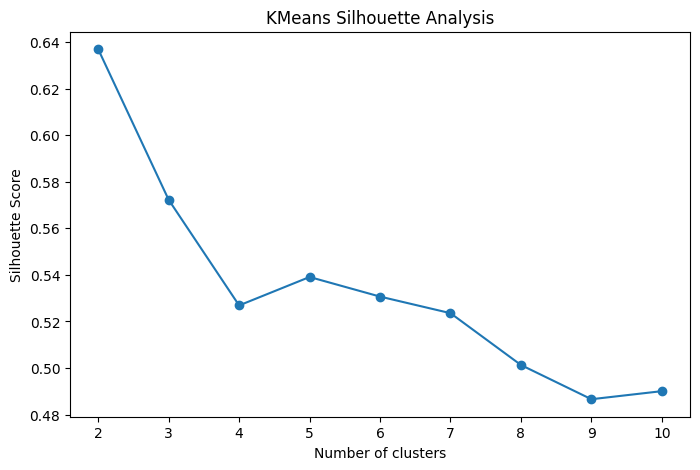

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27200\3380603415.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=1234))


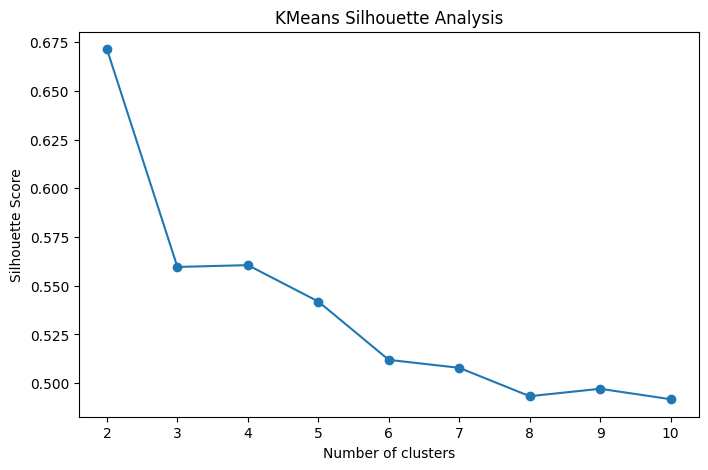

In [32]:
# -------------------------------------------------------------------------
# Example usage:
# Generate medA and medB clustering results using KMeans and DBSCAN
# -------------------------------------------------------------------------
medA_final_km, medA_clust_km = See_kmeans("medA")
medB_final_km, medB_clust_km = See_kmeans("medB")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27200\2062012380.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=1234))


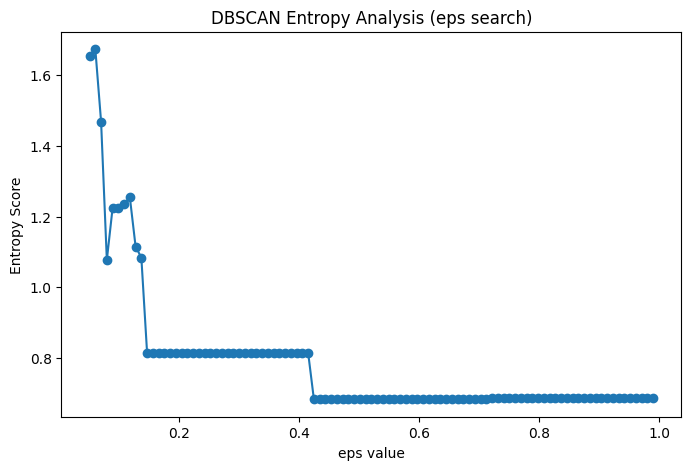

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27200\2062012380.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=1234))


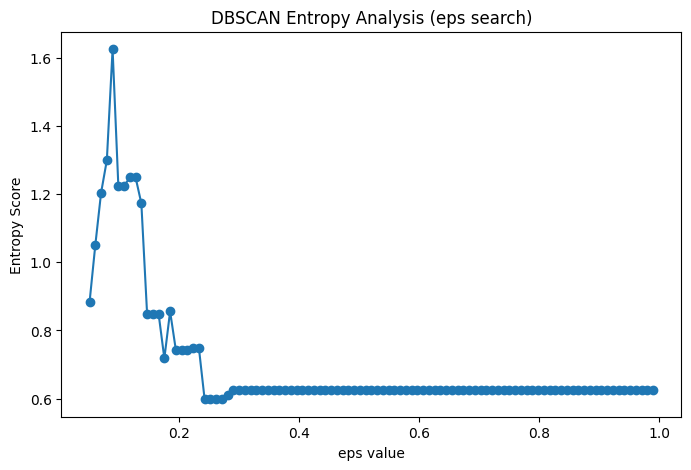

In [33]:
medA_final_db, medA_clust_db = See_dbscan("medA")
medB_final_db, medB_clust_db = See_dbscan("medB")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27200\2272106378.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='value', data=combined_df,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


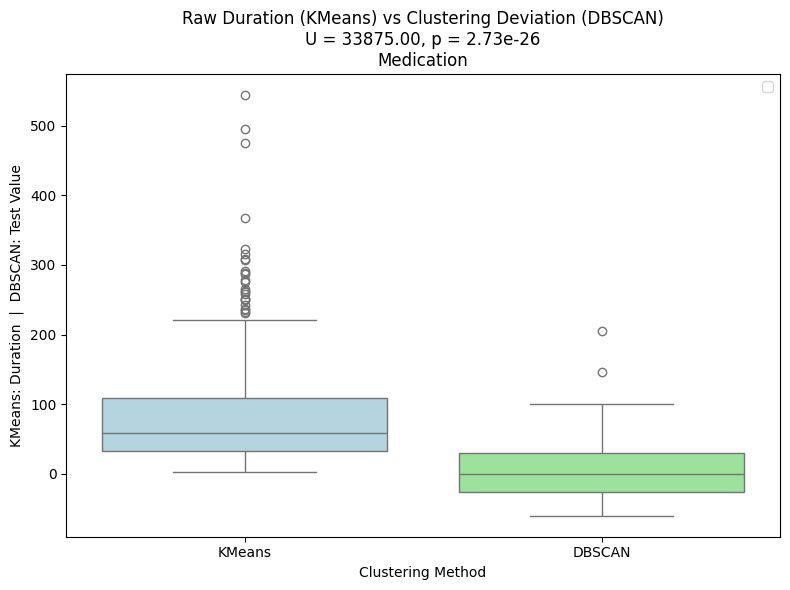

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27200\2272106378.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='value', data=combined_df,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


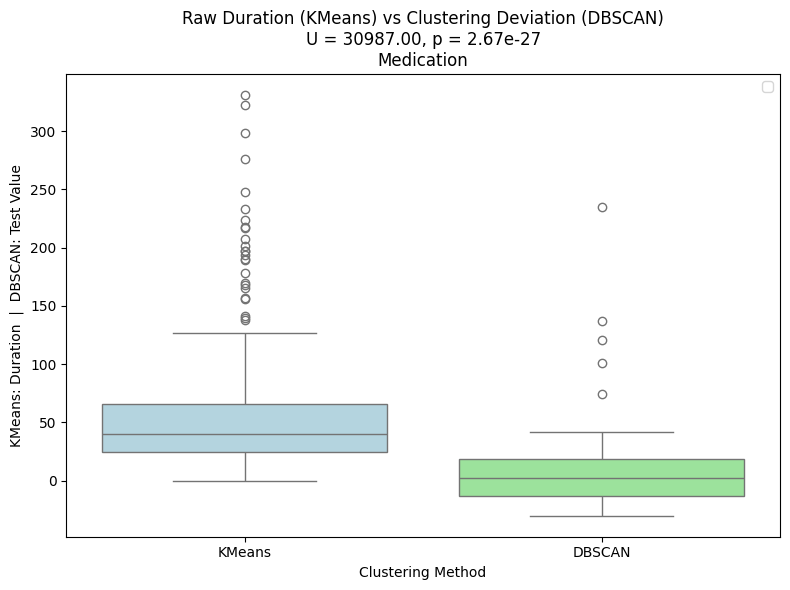

In [34]:
plot_cluster_comparison(medA_final_km, medA_clust_db)
plot_cluster_comparison(medB_final_km, medB_clust_db)

In [35]:
# Plot the assumption for medA and medB (using your original function)
def see_assumption(df):
    df_sorted = df.sort_values(['pnr', 'eksd']).copy()
    df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
    df_sorted['p_number'] = df_sorted.groupby('pnr').cumcount() + 1
    df2 = df_sorted[df_sorted['p_number'] >= 2].copy()
    df2 = df2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    df2['Duration'] = (df2['eksd'] - df2['prev_eksd']).dt.days
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=df2)
    medians = df2['Duration'].median()
    plt.axhline(y=medians, color='red', linestyle='--')
    plt.title("Duration by Prescription Number with Median Line")
    plt.xlabel("Prescription Number")
    plt.ylabel("Duration (days)")
    plt.show()

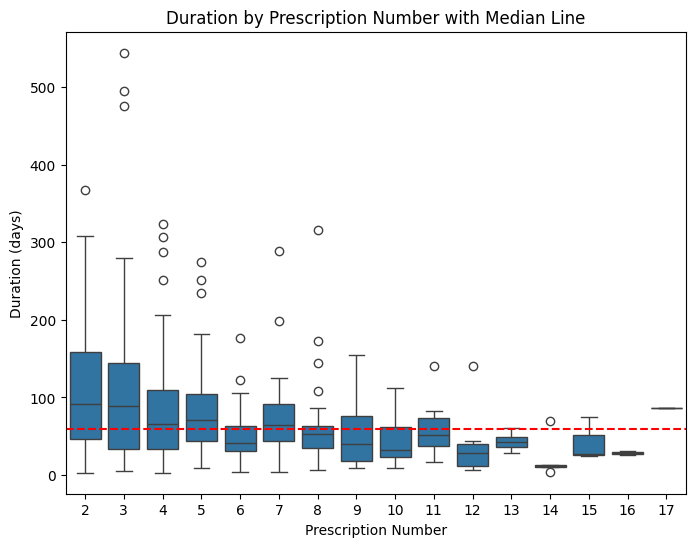

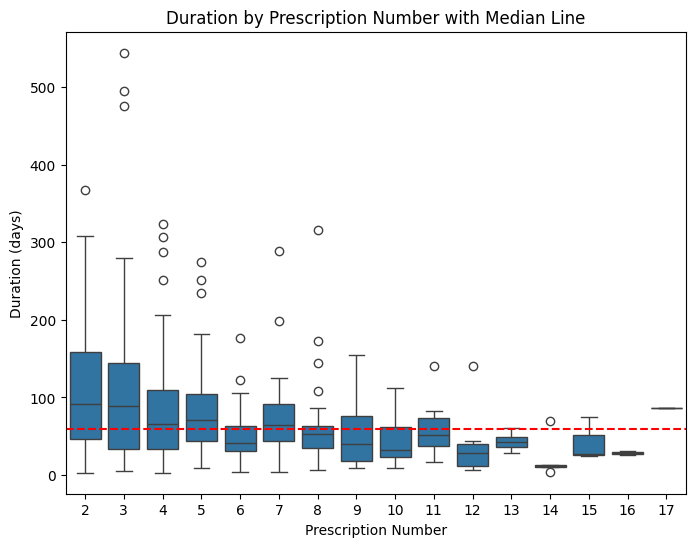

In [36]:
see_assumption(medA_final_km)
see_assumption(medA_final_db)

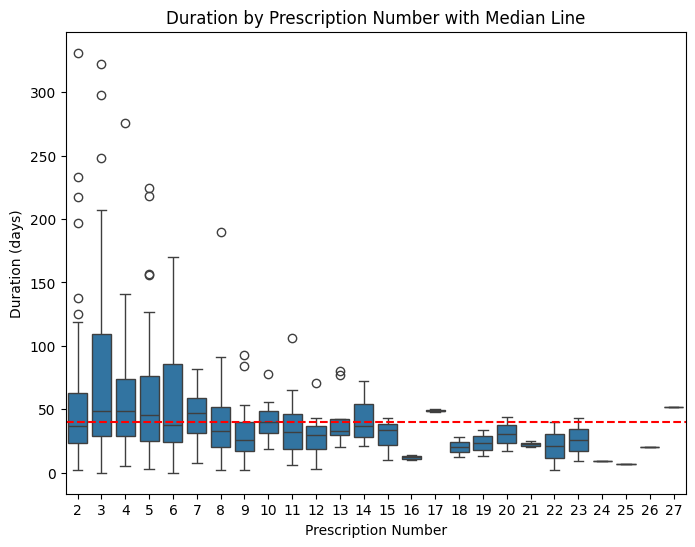

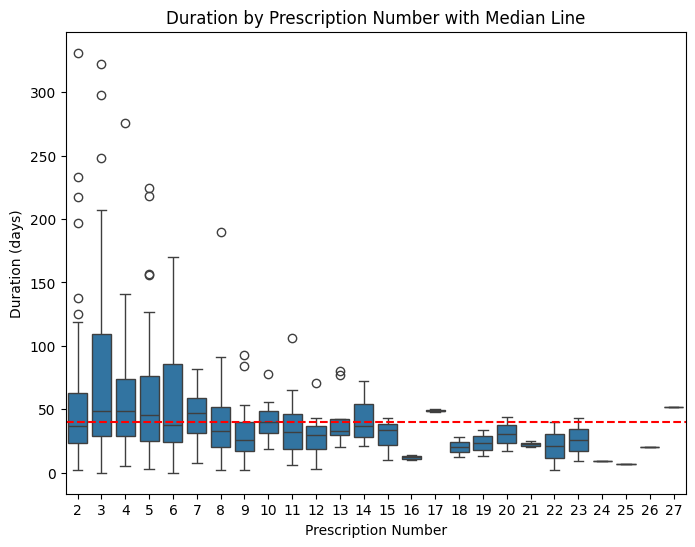

In [37]:
see_assumption(medB_final_km)
see_assumption(medB_final_db)